In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor,LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score,r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,WhiteKernel
%matplotlib inline

### Preprocessing

In [2]:
data = pd.read_csv('Merged_Data.csv')
data.head()

,Unnamed: 0,Date,HOUR_BIN,Citibike_Y,GreenTaxi_Y,YellowTaxi_Y,MTAExit_Y,MTAEntry_Y,temp,feelslike,...,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,Month,Day of Week
0,0,2018-01-01,0,400,11484.0,109663.0,283254.0,299794.0,-11.575,-16.850,...,9.350,304.25,1026.925,0.00,16.000,0.00,NaN,0.00,1,0
1,1,2018-01-01,4,233,4268.0,32370.0,137862.0,146343.0,-11.975,-16.600,...,7.775,292.75,1027.925,0.05,16.000,16.25,0.150,0.00,1,0
2,2,2018-01-01,8,1070,2275.0,42633.0,151154.0,196377.0,-9.025,-13.350,...,8.350,305.50,1028.500,0.25,15.525,330.25,1.175,3.50,1,0
3,3,2018-01-01,12,1830,4275.0,84638.0,328108.0,415589.0,-5.150,-8.175,...,7.075,320.50,1027.150,0.20,16.000,296.75,1.075,3.25,1,0
4,4,2018-01-01,16,1422,5761.0,81748.0,492717.0,594243.0,-6.350,-9.775,...,7.775,305.75,1027.750,0.20,16.000,2.50,0.000,0.00,1,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4380 entries, 0 to 4379
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        4380 non-null   int64  
 1   Date              4380 non-null   object 
 2   HOUR_BIN          4380 non-null   int64  
 3   Citibike_Y        4380 non-null   int64  
 4   GreenTaxi_Y       4380 non-null   float64
 5   YellowTaxi_Y      4380 non-null   float64
 6   MTAExit_Y         4380 non-null   float64
 7   MTAEntry_Y        4380 non-null   float64
 8   temp              4380 non-null   float64
 9   feelslike         4380 non-null   float64
 10  dew               4380 non-null   float64
 11  humidity          4380 non-null   float64
 12  precip            4380 non-null   float64
 13  precipprob        4380 non-null   float64
 14  snow              4380 non-null   float64
 15  snowdepth         4380 non-null   float64
 16  windgust          2332 non-null   float64


In [4]:
data = data.drop('Unnamed: 0',axis=1).dropna(axis=1).reset_index()
data =data.rename(columns={'index':'Day'})

In [5]:
def split_X_and_Y(data):
    list_=[]
    for i in data.columns:
        if '_Y' not in i:
            list_.append(i)
    X = data[list_].drop('Date',axis=1)
    Y_plot = data[['Date','YellowTaxi_Y']]
    Y = data[['YellowTaxi_Y']]
    return X,Y
X,Y = split_X_and_Y(data)

In [6]:
X.describe()

,Day,HOUR_BIN,temp,feelslike,dew,humidity,precip,precipprob,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,visibility,Month,Day of Week
count,4380.000000,4380.00000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000
mean,2189.500000,10.00000,32.767629,31.641096,23.847451,66.411185,0.168929,14.600457,0.009938,0.414431,9.182047,187.238761,1017.640556,23.261880,12.711252,6.526027,2.993151
std,1264.541419,6.83208,28.604967,29.872810,26.569764,17.552040,2.455728,28.391900,0.081623,1.877873,5.693534,99.282969,8.067116,22.528808,3.449083,3.448245,2.001928
min,0.000000,0.00000,-13.900000,-21.575000,-20.025000,15.270000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,988.000000,0.000000,1.150000,1.000000,0.000000
25%,1094.750000,4.00000,8.625000,6.900000,1.700000,53.334167,0.000000,0.000000,0.000000,0.000000,5.150000,88.000000,1012.400000,1.050000,9.900000,4.000000,1.000000
50%,2189.500000,10.00000,22.170833,21.825000,15.525000,65.510417,0.000000,0.000000,0.000000,0.000000,7.925000,217.375000,1017.750000,17.137500,14.387500,7.000000,3.000000
75%,3284.250000,16.00000,62.706250,62.706250,50.700000,81.000000,0.002250,25.000000,0.000000,0.000000,11.881250,268.000000,1022.850000,44.406250,16.000000,10.000000,5.000000
max,4379.000000,20.00000,95.750000,108.200000,75.925000,99.840000,73.935000,100.000000,2.667500,19.360000,39.100000,359.750000,1043.725000,100.000000,16.000000,12.000000,6.000000


In [7]:
categorical = ['HOUR_BIN','Month','Day of Week']

def onehotencoder(X,categorical):
    for i in categorical:
        X = X.drop(i,axis=1).merge(pd.get_dummies(X[i],prefix=i),left_index=True, right_index=True)
    return X
X_encoded = onehotencoder(X,categorical)

In [8]:
X_encoded.columns

Index(['Day', 'temp', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'snow', 'snowdepth', 'windspeed', 'winddir', 'sealevelpressure',
       'cloudcover', 'visibility', 'HOUR_BIN_0', 'HOUR_BIN_4', 'HOUR_BIN_8',
       'HOUR_BIN_12', 'HOUR_BIN_16', 'HOUR_BIN_20', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8',
       'Month_9', 'Month_10', 'Month_11', 'Month_12', 'Day of Week_0',
       'Day of Week_1', 'Day of Week_2', 'Day of Week_3', 'Day of Week_4',
       'Day of Week_5', 'Day of Week_6'],
      dtype='object')

### Finding good correlators

In [9]:
def bestcorrelators(X_encoded,n=10):
    Xs = X_encoded.columns
    n = min(n,len(X_encoded.columns))
    list_=[]
    for X in Xs:
        XN = X.replace(' ','_')
        temp = Y.merge(X_encoded[[X]],left_index=True, right_index=True).rename({X:XN},axis=1)
        formula = 'YellowTaxi_Y'+'~'+ XN
        lm = smf.ols(formula=formula,data=temp).fit()
        list_.append([X,lm.rsquared])
    bestn = pd.DataFrame(list_,columns = ['X','rsquared']).nlargest(n,'rsquared')
    return list(bestn['X'].reset_index(drop=True))
bestcorrelators(X_encoded)

['HOUR_BIN_4',
 'HOUR_BIN_0',
 'HOUR_BIN_16',
 'HOUR_BIN_12',
 'humidity',
 'Day',
 'HOUR_BIN_20',
 'windspeed',
 'HOUR_BIN_8',
 'dew']

### Creating a metric to evaluate the model

In [10]:
def evaluatemodel(y_pred,y_test,percentage=5):
    y_test = np.array(y_test).ravel()
    minimum = y_test*(1-percentage/100)
    maximum = y_test*(1+percentage/100)
    temp = (y_pred<=maximum) & (y_pred>=minimum)
    return temp.sum()/len(y_test)

### Finding and removing outliers in data to prevent the model from skewing

In [11]:
def removedensityoutliers(X_encoded,Y,factor=150):
    n = len(X_encoded)//factor
    temp = X_encoded.copy()
    anom = LocalOutlierFactor(n_neighbors=n, novelty=False)
    X_Out = anom.fit_predict(temp)
    temp['Outlier'] = X_Out
    indexes = temp[temp['Outlier'] == 1].index
    return X_encoded.iloc[indexes].reset_index(drop=True),Y.iloc[indexes].reset_index(drop=True)
X_Processed,Y_Processed = removedensityoutliers(X_encoded,Y)

In [12]:
X_Processed.shape[0]/X_encoded.shape[0]

0.9922374429223745

In [13]:
X_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4380 entries, 0 to 4379
Data columns (total 39 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Day               4380 non-null   int64  
 1   temp              4380 non-null   float64
 2   feelslike         4380 non-null   float64
 3   dew               4380 non-null   float64
 4   humidity          4380 non-null   float64
 5   precip            4380 non-null   float64
 6   precipprob        4380 non-null   float64
 7   snow              4380 non-null   float64
 8   snowdepth         4380 non-null   float64
 9   windspeed         4380 non-null   float64
 10  winddir           4380 non-null   float64
 11  sealevelpressure  4380 non-null   float64
 12  cloudcover        4380 non-null   float64
 13  visibility        4380 non-null   float64
 14  HOUR_BIN_0        4380 non-null   uint8  
 15  HOUR_BIN_4        4380 non-null   uint8  
 16  HOUR_BIN_8        4380 non-null   uint8  


### Building a Model

In [14]:
Number_of_predictors = 25
Outlier_Factor = 350

s=np.linspace(10,30,20)
s = s.astype(int)

X_Processed,Y_Processed = removedensityoutliers(X_encoded,Y,Outlier_Factor)

Y_array = np.array(Y_Processed['YellowTaxi_Y'])
X_train, X_test, y_train, y_test = train_test_split(X_Processed,Y_array+0.00001, test_size=0.25, random_state=123)


#finding the best correlators from training data
Xs = bestcorrelators(X_train,Number_of_predictors)

print(Xs)


#Using only those features
X_train = np.array(X_train[Xs])
X_test = np.array(X_test[Xs])


#Standardizing the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)


#Testing out different models
param_grid_lr = {}
lr = LinearRegression()

param_grid_svr = {'kernel':['rbf'],'degree':range(30,31),'gamma':['scale','auto']}
svr = SVR()

param_grid_sgd = {'penalty':['l1','l2'],'alpha':[1e-6,1e-5,1e-4,1e-3,1e-2],'max_iter':[100000]}
sgd=SGDRegressor()


param_grid_dtr = {'random_state':[123],'min_samples_leaf':[0.001],'max_depth':s,'splitter':['best'],'criterion':['squared_error','friedman_mse','poisson'],'max_features':[1,'sqrt','log2'],'ccp_alpha':[1e-2,1e-1,1]}
dtr=DecisionTreeRegressor()


param_grid_rfr = {'n_estimators':[1000],'criterion':['squared_error','absolute_error','poisson'],'max_features':['sqrt','log2',None],'ccp_alpha':[1e-2,1e-1]}
rfr = RandomForestRegressor()


param_grid_gbr = {'loss':['squared_error','absolute_error'],'criterion': ['friedman_mse','squared_error'],'learning_rate':[0.01,0.1],'n_estimators':[1000,2000],'ccp_alpha':[1,1e-1]}
gbr = GradientBoostingRegressor()



#Using gridsearch for hyperparamter optimization


#Linear methods
#gr=GridSearchCV(lr,param_grid=param_grid_lr,cv=5,)
#gr=GridSearchCV(svr,param_grid=param_grid_svr,cv=5)
#gr=GridSearchCV(sgd,param_grid=param_grid_sgd,cv=5)
#gr.fit(X_train,np.log(np.array(y_train)).ravel())


#Tree and ensemble based

#gr=GridSearchCV(dtr,param_grid=param_grid_dtr,cv=2)
gr=GridSearchCV(rfr,param_grid=param_grid_rfr,cv=2,verbose=3)
#gr =GridSearchCV(gbr,param_grid=param_grid_gbr,cv=2,verbose=1)
gr.fit(X_train,np.array(y_train).ravel())                  

#Output the best parameter
gr.best_params_

['Day', 'feelslike', 'temp', 'dew', 'Month_8', 'Month_3', 'windspeed', 'Month_7', 'Month_4', 'Month_9', 'Month_2', 'HOUR_BIN_0', 'HOUR_BIN_4', 'HOUR_BIN_16', 'HOUR_BIN_12', 'Month_5', 'visibility', 'precip', 'winddir', 'precipprob', 'HOUR_BIN_8', 'sealevelpressure', 'HOUR_BIN_20', 'Month_11', 'Month_10']
Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV 1/2] END ccp_alpha=0.01, criterion=squared_error, max_features=sqrt, n_estimators=1000;, score=0.799 total time=   1.9s
[CV 2/2] END ccp_alpha=0.01, criterion=squared_error, max_features=sqrt, n_estimators=1000;, score=0.789 total time=   1.9s
[CV 1/2] END ccp_alpha=0.01, criterion=squared_error, max_features=log2, n_estimators=1000;, score=0.796 total time=   1.6s
[CV 2/2] END ccp_alpha=0.01, criterion=squared_error, max_features=log2, n_estimators=1000;, score=0.787 total time=   1.7s
[CV 1/2] END ccp_alpha=0.01, criterion=squared_error, max_features=None, n_estimators=1000;, score=0.803 total time=   5.5s
[CV 2/2] END 

{'ccp_alpha': 0.1,
 'criterion': 'absolute_error',
 'max_features': None,
 'n_estimators': 1000}

<b> In sample error

In [15]:
#If using lr,svr or sgd
y_pred = gr.predict(X_train)
evaluatemodel(y_pred,np.log(y_train),10)

0.0

In [16]:
#If using tre based methods
y_pred = gr.predict(X_train)
evaluatemodel(y_pred,y_train,15)

0.8102437519284171

<b> Out of sample error

In [17]:
#Ifusing lr,svr or sgd
y_pred = gr.predict(X_test)
evaluatemodel(y_pred,np.log(y_test),10)

0.0

In [18]:
#if using tre based methods
y_pred = gr.predict(X_test)
evaluatemodel(y_pred,y_test,15)

0.574468085106383

In [19]:
predictions =  pd.DataFrame([y_test,y_pred]).transpose().sort_values(0).reset_index(drop=True).rename({0:'Actual',1:'Predicted'},axis=1)
#predictions =  pd.DataFrame([np.exp(y_test),np.exp(y_pred)]).transpose().sort_values(1).reset_index(drop=True)

<AxesSubplot:>

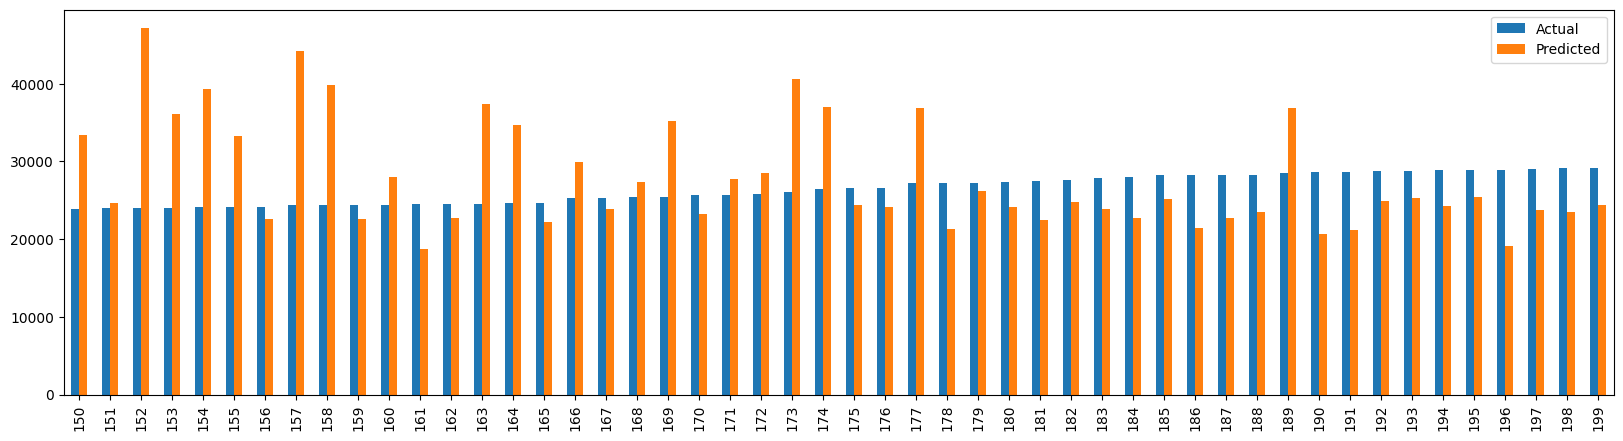

In [20]:
predictions[150:200].plot.bar(figsize=(20,5))